# **Project Name**    - Flight Price Prediction

# **GitHub Link -**

https://github.com/Deeppatel0510/Voyage-Analytics-Integrating-MLOps-in-Travel/tree/main

#**Importing Necessary Libraries**

In [ ]:
# Data visualization
# Importing necessary libraries
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importing necessary libraries
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




#**Data Ingestion**

In [ ]:
flight_df=pd.read_csv("/content/drive/MyDrive/Master Degree Capstone/flights.csv",on_bad_lines='skip')
hotel_df=pd.read_csv("/content/drive/MyDrive/Master Degree Capstone/hotels.csv",on_bad_lines='skip')
user_df=pd.read_csv("/content/drive/MyDrive/Master Degree Capstone/users.csv",on_bad_lines='skip')

In [ ]:
# Display the first few rows of the flight dataset
flight_df.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019


In [ ]:
# Function to calculate price per km
def price_km(price, distance):
    if distance == 0:  # Avoid division by zero
        return 0
    return price / distance

# Apply the function to create a new column
flight_df['price_per_km'] = flight_df.apply(lambda row: price_km(row['price'], row['distance']), axis=1)



---


#**Data Mining and Exploration**

In [ ]:
# Total no. of rows in the dataset

df_list=[flight_df,hotel_df,user_df]
df_name_list=['flight_df','hotel_df','user_df']

for i in df_name_list:
  if i == 'flight_df':
    print(f'Total no. of rows in {i}: {len(df_list[0])}')
  elif i == 'hotel_df':
    print(f'Total no. of rows in {i}: {len(df_list[1])}')
  else:
    print(f'Total no. of rows in user_df: {len(df_list[2])}')

Total no. of rows in flight_df: 271888
Total no. of rows in hotel_df: 40552
Total no. of rows in user_df: 1340


In [ ]:
# Overall Information of Dataset

for i in df_name_list:
  if i == 'flight_df':
    print(f'Information about {i}')
    print(df_list[0].info())
  elif i == 'hotel_df':
    print(f'Information about {i}')
    print(df_list[1].info())
  else:
    print(f'Information about {i}')
    print(df_list[2].info())

Information about flight_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   travelCode    271888 non-null  int64  
 1   userCode      271888 non-null  int64  
 2   from          271888 non-null  object 
 3   to            271888 non-null  object 
 4   flightType    271888 non-null  object 
 5   price         271888 non-null  float64
 6   time          271888 non-null  float64
 7   distance      271888 non-null  float64
 8   agency        271888 non-null  object 
 9   date          271888 non-null  object 
 10  price_per_km  271888 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 22.8+ MB
None
Information about hotel_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0  

In [ ]:
flight_df.describe(include='object')

,from,to,flightType,agency,date
count,271888,271888,271888,271888,271888
unique,9,9,3,3,999
top,Florianopolis (SC),Florianopolis (SC),firstClass,Rainbow,09/26/2019
freq,57317,57317,116418,116752,1335


In [ ]:
# Summary statistics of numeric columns

for i in df_name_list:
  if i == 'flight_df':
    print(i)
    print(df_list[0].describe())
  elif i == 'hotel_df':
    print(i)
    print(df_list[1].describe())
  else:
    print(i)
    print(df_list[2].describe())

flight_df
          travelCode       userCode         price           time  \
count  271888.000000  271888.000000  271888.00000  271888.000000   
mean    67971.500000     667.505495     957.37503       1.421147   
std     39243.724665     389.523127     362.31189       0.542541   
min         0.000000       0.000000     301.51000       0.440000   
25%     33985.750000     326.000000     672.66000       1.040000   
50%     67971.500000     659.000000     904.00000       1.460000   
75%    101957.250000    1011.000000    1222.24000       1.760000   
max    135943.000000    1339.000000    1754.17000       2.440000   

            distance   price_per_km  
count  271888.000000  271888.000000  
mean      546.955535       1.900932  
std       208.851288       0.699544  
min       168.220000       0.672571  
25%       401.660000       1.388011  
50%       562.140000       1.814960  
75%       676.530000       2.283543  
max       937.770000       4.069968  
hotel_df
          travelCode      

In [ ]:
# Check for Missing Values

for i in df_name_list:
  if i == 'flight_df':
    print(f'Total no. of null rows in {i}: {df_list[0].isnull().sum()}')
  elif i == 'hotel_df':
    print(f'Total no. of null rows in {i}: {df_list[1].isnull().sum()}')
  else:
    print(f'Total no. of null rows in user_df: {df_list[2].isnull().sum()}')

Total no. of null rows in flight_df: travelCode      0
userCode        0
from            0
to              0
flightType      0
price           0
time            0
distance        0
agency          0
date            0
price_per_km    0
dtype: int64
Total no. of null rows in hotel_df: travelCode    0
userCode      0
name          0
place         0
days          0
price         0
total         0
date          0
dtype: int64
Total no. of null rows in user_df: code       0
company    0
name       0
gender     0
age        0
dtype: int64


In [ ]:
# Check for Duplicate rows

for i in df_name_list:
  if i == 'flight_df':
    print(f'Total no. of duplicate rows in {i}: {df_list[0].duplicated().sum()}')
  elif i == 'hotel_df':
    print(f'Total no. of duplicate rows in {i}: {df_list[1].duplicated().sum()}')
  else:
    print(f'Total no. of duplicate rows in user_df: {df_list[2].duplicated().sum()}')

Total no. of duplicate rows in flight_df: 0
Total no. of duplicate rows in hotel_df: 0
Total no. of duplicate rows in user_df: 0


##**Correcting the data type of date coulmn to datetime**

In [ ]:
# Converting date coulmn data type into datetime

flight_df['date'] = pd.to_datetime(flight_df['date'])

# Extracting WeekNo., Month, Year, Weekday from date column

flight_df['week_day'] = flight_df['date'].dt.weekday
flight_df['month'] = flight_df['date'].dt.month
flight_df['week_no'] = flight_df['date'].dt.isocalendar().week
flight_df['year'] = flight_df['date'].dt.year
flight_df['day'] = flight_df['date'].dt.day

In [ ]:
# Display the first few rows of the flight dataset
flight_df.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date,price_per_km,week_day,month,week_no,year,day
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,2019-09-26,2.120202,3,9,39,2019,26
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,2019-09-30,1.910174,0,9,40,2019,30
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,2019-10-03,2.333145,3,10,40,2019,3
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,2019-10-04,1.768241,4,10,40,2019,4
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,2019-10-10,2.026876,3,10,41,2019,10


In [ ]:
flight_filtered_df= flight_df[['from','to','flightType','agency','time','distance','day','month','year','week_day','week_no','price']]
flight_filtered_df.head()

,from,to,flightType,agency,time,distance,day,month,year,week_day,week_no,price
0,Recife (PE),Florianopolis (SC),firstClass,FlyingDrops,1.76,676.53,26,9,2019,3,39,1434.38
1,Florianopolis (SC),Recife (PE),firstClass,FlyingDrops,1.76,676.53,30,9,2019,0,40,1292.29
2,Brasilia (DF),Florianopolis (SC),firstClass,CloudFy,1.66,637.56,3,10,2019,3,40,1487.52
3,Florianopolis (SC),Brasilia (DF),firstClass,CloudFy,1.66,637.56,4,10,2019,4,40,1127.36
4,Aracaju (SE),Salvador (BH),firstClass,CloudFy,2.16,830.86,10,10,2019,3,41,1684.05


In [ ]:
flight_filtered_df.shape

(271888, 12)



#**Exploratory Data Analysis**

In [ ]:
# Select only numeric columns before calculating skewness
numeric_columns = flight_filtered_df.select_dtypes(include=['number'])
skewness = numeric_columns.skew()
print(skewness)

time       -0.179825
distance   -0.183944
day         0.006463
month      -0.039119
year        0.378661
week_day   -0.441701
week_no    -0.030191
price       0.313578
dtype: Float64


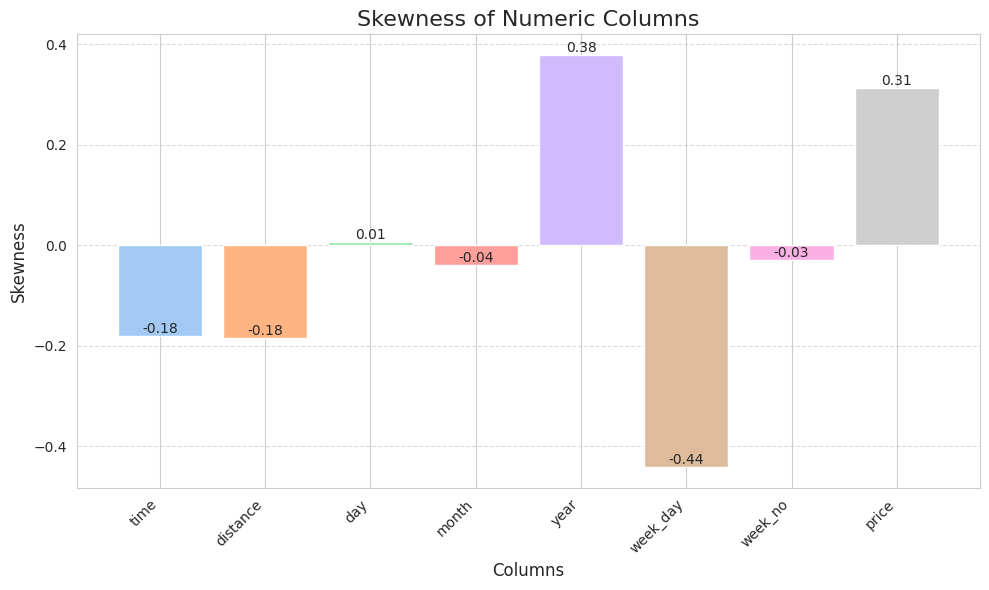

In [ ]:
# Select only numeric columns before calculating skewness
numeric_columns = flight_filtered_df.select_dtypes(include=['number'])
skewness = numeric_columns.skew()

# Plot skewness for numeric columns
plt.figure(figsize=(10, 6))
colors = sns.color_palette("pastel", len(skewness))  # Use a pastel color palette

bars = plt.bar(skewness.index, skewness.values, color=colors)
plt.title('Skewness of Numeric Columns', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Skewness', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display skewness values on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

From the above result, we can check which variable is normally distributed and which is not.

The variables with skewness > 1 price are highly positively skewed.

The variables with skewness < -1 are highly negatively skewed.

The variables with 0.5 < skewness < 1 are moderately positively skewed.

The variables with -0.5 < skewness < -1 are moderately negatively skewed.

And, the variables with -0.5 < skewness < 0.5 are symmetric i.e normally distributed such as symboling, carheight, boreration, peakrpm, highwaympg.

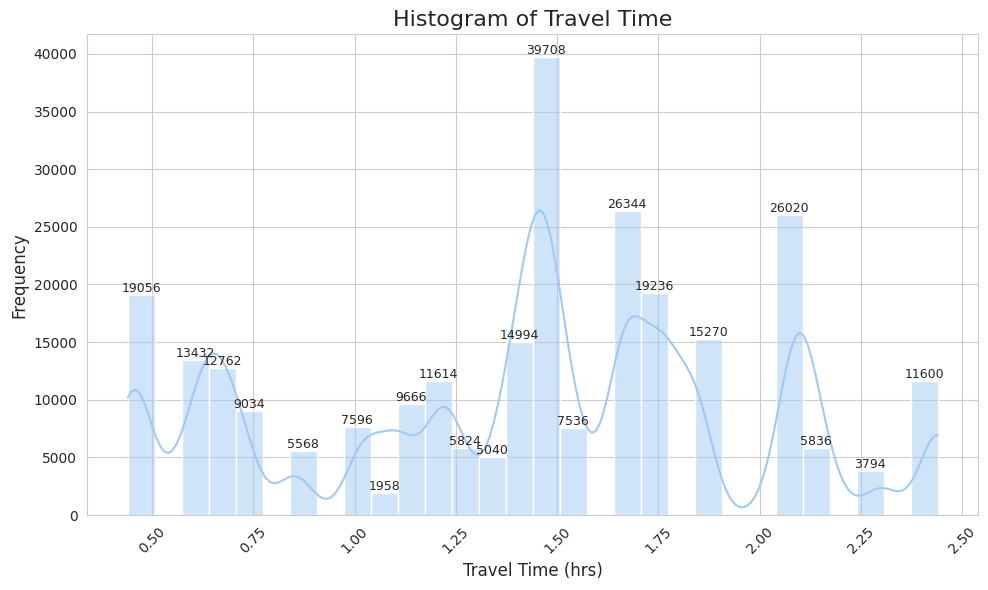

In [ ]:
# Set the style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Plot
plt.figure(figsize=(10, 6))
hist_plot = sns.histplot(flight_filtered_df['time'], bins=30, kde=True)

# Beautify the chart
plt.title('Histogram of Travel Time', fontsize=16)
plt.xlabel('Travel Time (hrs)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on top of each histogram bar
for patch in hist_plot.patches:
    height = patch.get_height()
    if height > 0:
        plt.text(patch.get_x() + patch.get_width() / 2,
                 height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Inference from the plot:

The histogram shows the distribution of travel time, with the x-axis representing the travel time and the y-axis representing the frequency (i.e., the number of occurrences) of these travel time.

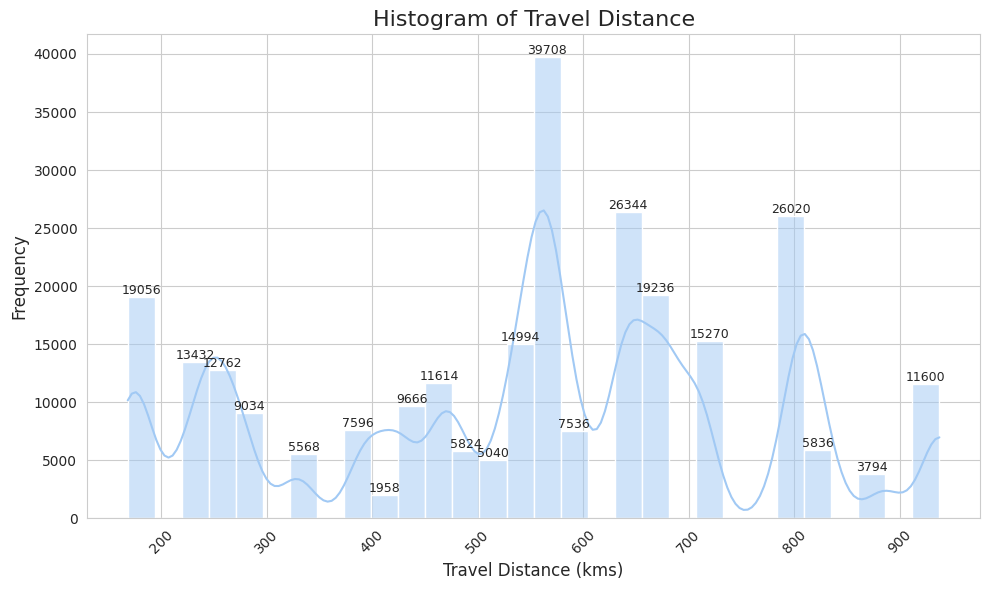

In [ ]:
# Set Seaborn style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Plot
plt.figure(figsize=(10, 6))
hist_plot = sns.histplot(flight_filtered_df['distance'], bins=30, kde=True)

# Beautify the chart
plt.title('Histogram of Travel Distance', fontsize=16)
plt.xlabel('Travel Distance (kms)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)

# Add value labels to histogram bars
for patch in hist_plot.patches:
    height = patch.get_height()
    if height > 0:
        plt.text(patch.get_x() + patch.get_width() / 2,
                 height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Inference from the plot:

The histogram shows the distribution of travel distance, with the x-axis representing the travel distance and the y-axis representing the frequency (i.e., the number of occurrences) of these travel distance.

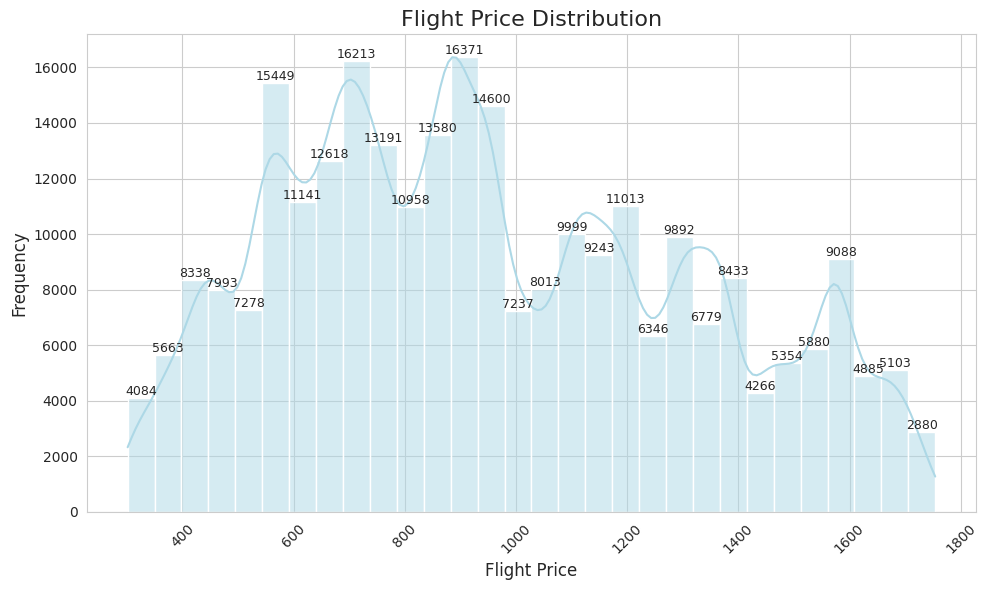

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Plot
plt.figure(figsize=(10, 6))
hist_plot = sns.histplot(flight_filtered_df['price'], bins=30, kde=True, color='lightblue')

# Beautify chart
plt.title('Flight Price Distribution', fontsize=16)
plt.xlabel('Flight Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for patch in hist_plot.patches:
    height = patch.get_height()
    if height > 0:
        plt.text(patch.get_x() + patch.get_width() / 2,
                 height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Inference from the plot:

The majority of the prices seem to be concentrated in a relatively narrow range, indicating a common price range for these travel packages.

There is a long tail on the right side of the distribution, suggesting that there are a few travel packages with significantly higher prices compared to the majority.

The distribution appears to be right-skewed, with prices tapering off as they increase.

Overall, this plot provides insight into the distribution of prices, which is valuable information for understanding the pricing structure of the travel packages in the dataset.

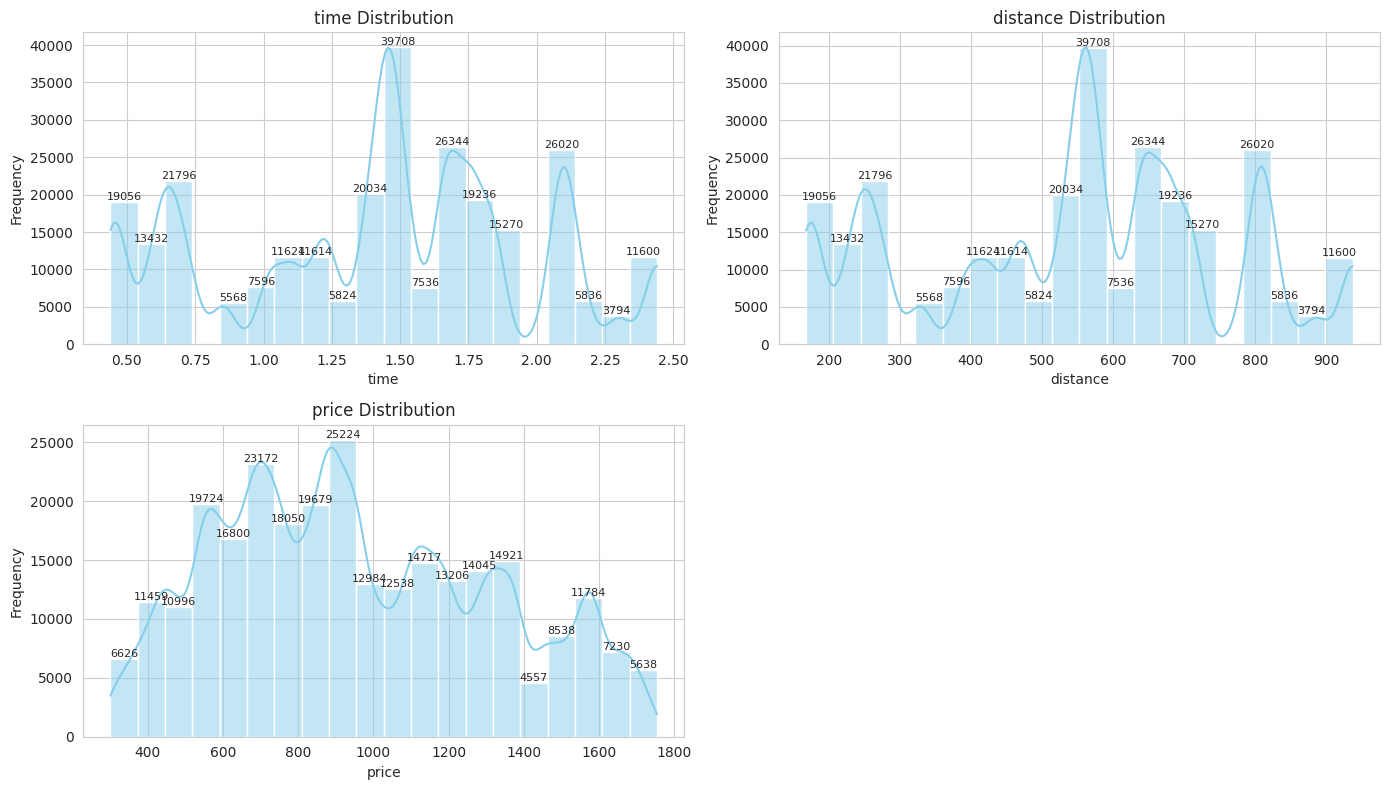

In [ ]:
# Set style
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Select numeric columns
numeric_cols = flight_filtered_df.select_dtypes(include=['int64', 'float64']).columns

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=(len(numeric_cols) + 1) // 2, figsize=(14, 8))
axes = axes.flatten()

# Plot histograms for each numeric column
for i, col in enumerate(numeric_cols):
    sns.histplot(flight_filtered_df[col], bins=20, ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f'{col} Distribution', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency')

    # Add value labels
    for patch in axes[i].patches:
        height = patch.get_height()
        if height > 0:
            axes[i].text(patch.get_x() + patch.get_width()/2, height,
                         f'{int(height)}',
                         ha='center', va='bottom', fontsize=8)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **Check for Outliers in Numerical Coulmns using Box-plot**

If the distribution of numerical column follows normal distribution, then use std to handle outliers.

Otherwise we will use IQR technique

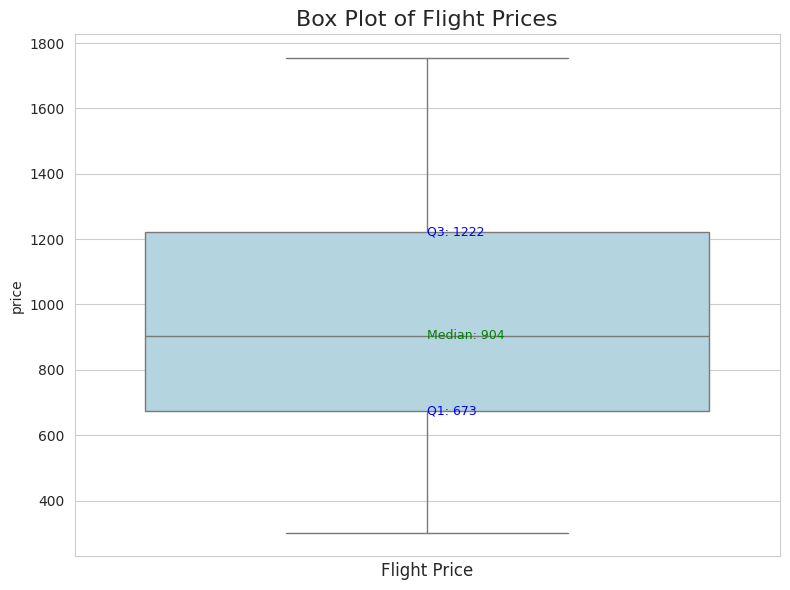

In [ ]:
# Set style
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Extract column
price_data = flight_filtered_df['price']

# Plot
plt.figure(figsize=(8, 6))
box = sns.boxplot(data=price_data, color='lightblue')

# Add title and labels
plt.title('Box Plot of Flight Prices', fontsize=16)
plt.xlabel('Flight Price', fontsize=12)
plt.xticks([])  # Optional: remove x-tick since only one box

# Add annotations: quartiles
q1 = price_data.quantile(0.25)
q2 = price_data.quantile(0.5)
q3 = price_data.quantile(0.75)

plt.text(0, q1, f'Q1: {q1:.0f}', ha='left', va='center', fontsize=9, color='blue')
plt.text(0, q2, f'Median: {q2:.0f}', ha='left', va='center', fontsize=9, color='green')
plt.text(0, q3, f'Q3: {q3:.0f}', ha='left', va='center', fontsize=9, color='blue')

# Annotate outliers (optional: limit to top 5 extreme for clarity)
outliers = price_data[(price_data < q1 - 1.5 * (q3 - q1)) | (price_data > q3 + 1.5 * (q3 - q1))]
for y in outliers.head(5):
    plt.text(0, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.show()

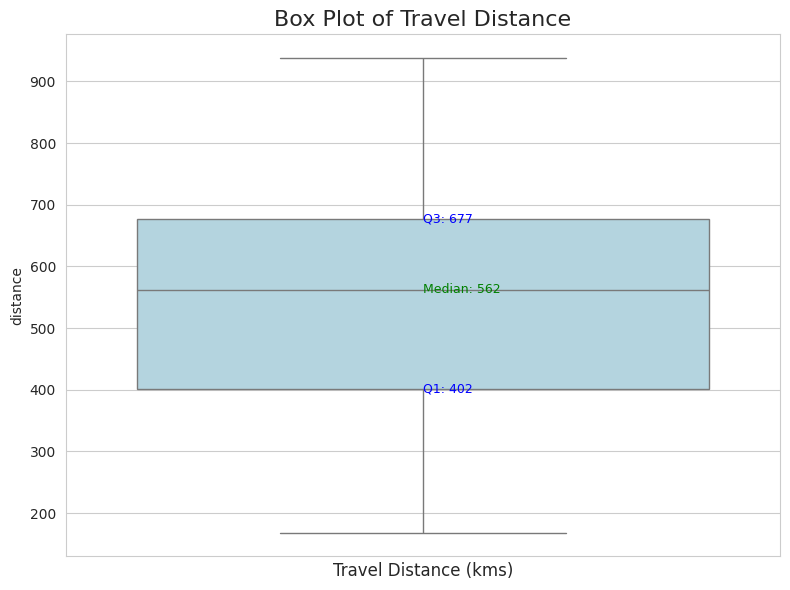

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Extract distance data
distance_data = flight_filtered_df['distance']

# Plot boxplot for distance
plt.figure(figsize=(8, 6))
box = sns.boxplot(data=distance_data, color='lightblue')

# Add title and labels
plt.title('Box Plot of Travel Distance', fontsize=16)
plt.xlabel('Travel Distance (kms)', fontsize=12)
plt.xticks([])  # Optional: remove x-tick since only one box

# Annotate quartiles
q1 = distance_data.quantile(0.25)
q2 = distance_data.quantile(0.5)
q3 = distance_data.quantile(0.75)

plt.text(0, q1, f'Q1: {q1:.0f}', ha='left', va='center', fontsize=9, color='blue')
plt.text(0, q2, f'Median: {q2:.0f}', ha='left', va='center', fontsize=9, color='green')
plt.text(0, q3, f'Q3: {q3:.0f}', ha='left', va='center', fontsize=9, color='blue')

# Annotate outliers (optional: limit to top 5 extreme for clarity)
outliers = distance_data[(distance_data < q1 - 1.5 * (q3 - q1)) | (distance_data > q3 + 1.5 * (q3 - q1))]
for y in outliers.head(5):
    plt.text(0, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.show()

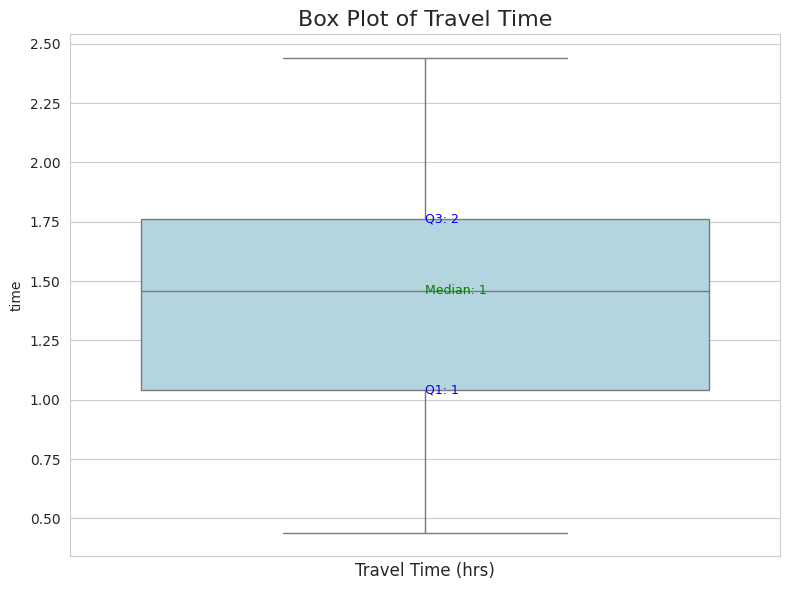

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Extract time data
time_data = flight_filtered_df['time']

# Plot boxplot for time
plt.figure(figsize=(8, 6))
box = sns.boxplot(data=time_data, color='lightblue')

# Add title and labels
plt.title('Box Plot of Travel Time', fontsize=16)
plt.xlabel('Travel Time (hrs)', fontsize=12)
plt.xticks([])  # Optional: remove x-tick since only one box

# Annotate quartiles
q1 = time_data.quantile(0.25)
q2 = time_data.quantile(0.5)
q3 = time_data.quantile(0.75)

plt.text(0, q1, f'Q1: {q1:.0f}', ha='left', va='center', fontsize=9, color='blue')
plt.text(0, q2, f'Median: {q2:.0f}', ha='left', va='center', fontsize=9, color='green')
plt.text(0, q3, f'Q3: {q3:.0f}', ha='left', va='center', fontsize=9, color='blue')

# Annotate outliers (optional: limit to top 5 extreme for clarity)
outliers = time_data[(time_data < q1 - 1.5 * (q3 - q1)) | (time_data > q3 + 1.5 * (q3 - q1))]
for y in outliers.head(5):
    plt.text(0, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.show()

### **Distribution of Categories in Categorical Coulmns using a Count-plot**

In [ ]:
flight_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   from        271888 non-null  object 
 1   to          271888 non-null  object 
 2   flightType  271888 non-null  object 
 3   agency      271888 non-null  object 
 4   time        271888 non-null  float64
 5   distance    271888 non-null  float64
 6   day         271888 non-null  int32  
 7   month       271888 non-null  int32  
 8   year        271888 non-null  int32  
 9   week_day    271888 non-null  int32  
 10  week_no     271888 non-null  UInt32 
 11  price       271888 non-null  float64
dtypes: UInt32(1), float64(3), int32(4), object(4)
memory usage: 20.0+ MB


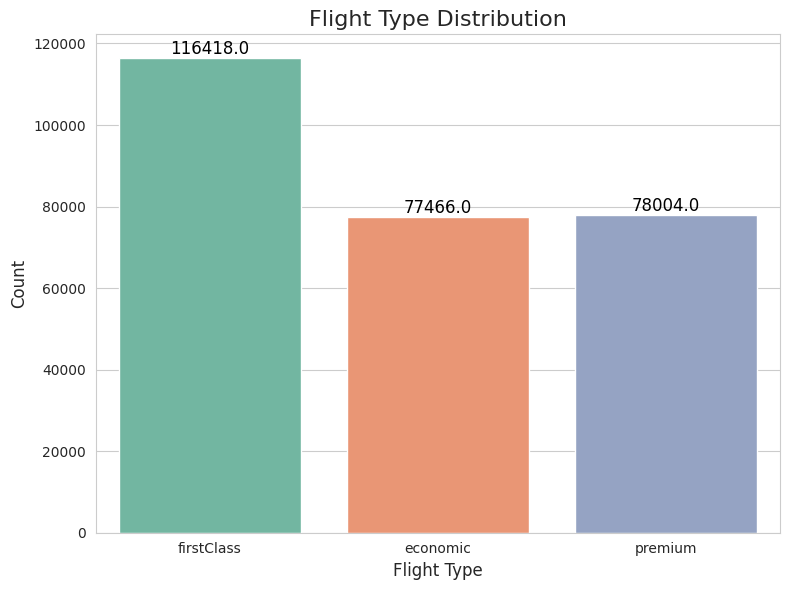

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Create count plot
plt.figure(figsize=(8, 6))
count_plot = sns.countplot(x='flightType', data=flight_filtered_df, palette='Set2')

# Add title and labels
plt.title('Flight Type Distribution', fontsize=16)
plt.xlabel('Flight Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate counts on top of bars
for p in count_plot.patches:
    count_plot.annotate(f'{p.get_height()}',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

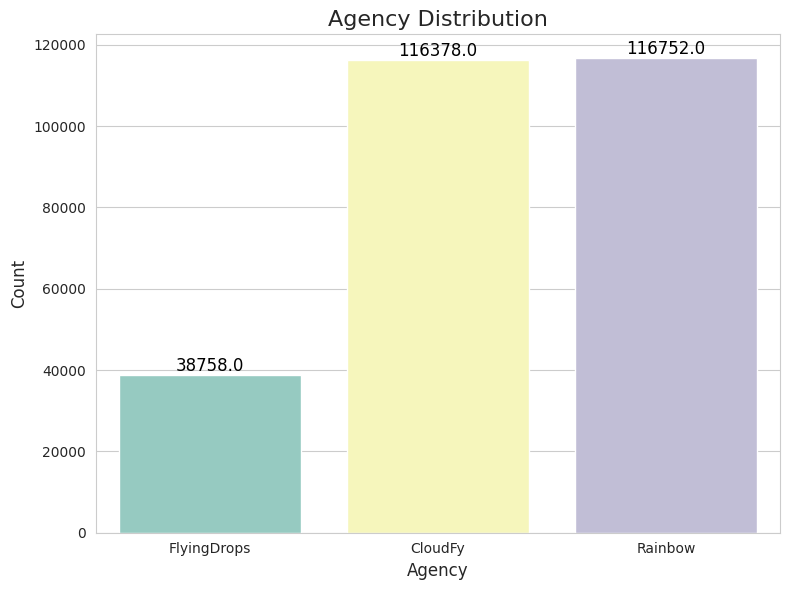

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('Set3')

# Create count plot
plt.figure(figsize=(8, 6))
count_plot = sns.countplot(x='agency', data=flight_filtered_df, palette='Set3')

# Add title and labels
plt.title('Agency Distribution', fontsize=16)
plt.xlabel('Agency', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate counts on top of bars
for p in count_plot.patches:
    count_plot.annotate(f'{p.get_height()}',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

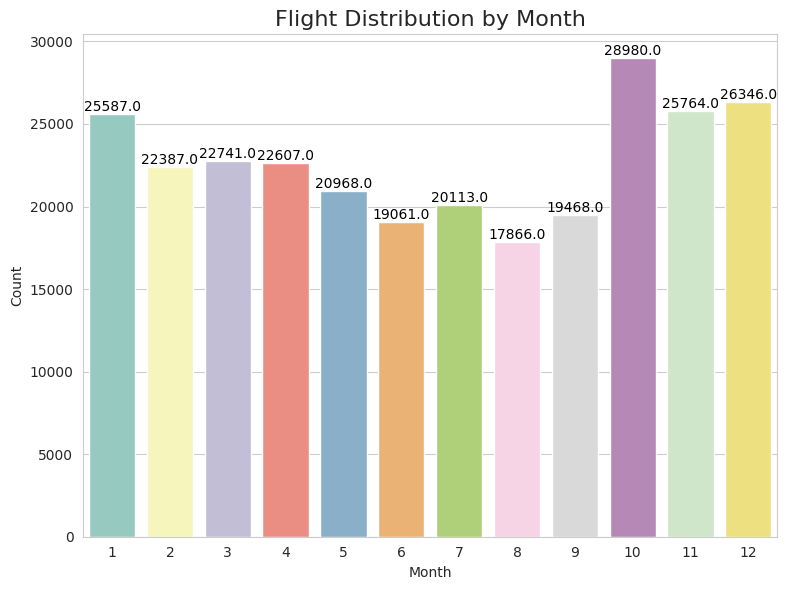

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('Set3')

# Create count plot
plt.figure(figsize=(8, 6))
count_plot = sns.countplot(x='month', data=flight_filtered_df, palette='Set3')

# Add title and labels
plt.title('Flight Distribution by Month', fontsize=16)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Annotate counts on top of bars
for p in count_plot.patches:
    count_plot.annotate(f'{p.get_height()}',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### **Distribution of Categories in Categorical Coulmns using a pie-chart**

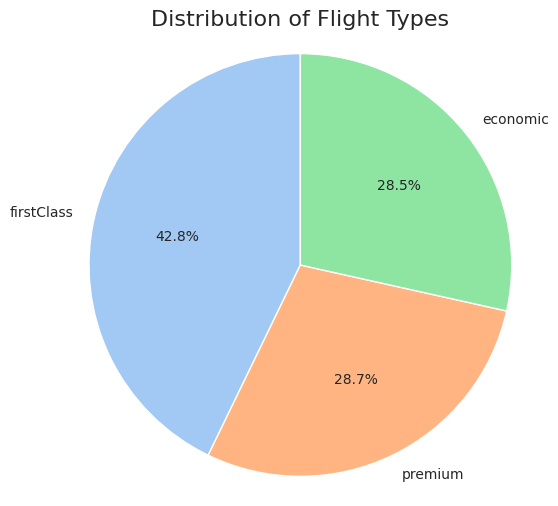

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Get the counts of each flight type
flight_type_counts = flight_filtered_df['flightType'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(flight_type_counts, labels=flight_type_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel", len(flight_type_counts)))

# Add title and improve appearance
plt.title('Distribution of Flight Types', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

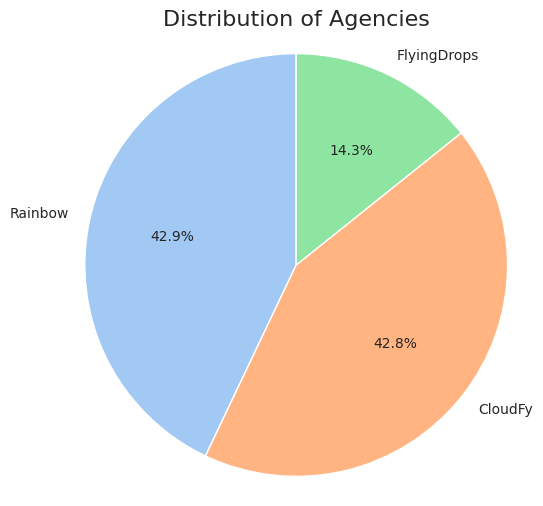

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Get the counts of each agency
agency_type_counts = flight_filtered_df['agency'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(agency_type_counts,
        labels=agency_type_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel", len(agency_type_counts)))

# Add title and improve appearance
plt.title('Distribution of Agencies', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

Inference from the plot:

The pie chart illustrates the distribution of selected package types in the dataset. The data is categorized into five package types: Deluxe, Standard, Premium, Luxury, and Budget.

Deluxe and Standard are the most common package types, each making up a significant portion of the dataset.
Premium is also fairly common, but slightly less frequent than Deluxe and Standard.
Luxury packages are less common but still represent a substantial portion of the dataset.
Budget packages are the least common among the selected types, comprising a relatively small percentage of the dataset.

<Figure size 800x500 with 0 Axes>

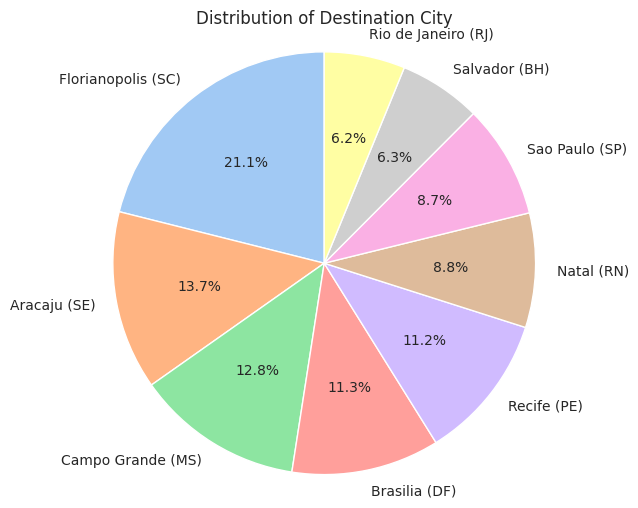

In [ ]:
# Data visualization with improved aesthetics
sns.set_style('whitegrid')
sns.set_palette('pastel')
plt.figure(figsize=(8,5))  # Reduced figure size
# Data visualization
# Get the counts of each destination_city_counts
destination_city_counts = flight_filtered_df['to'].value_counts()

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(destination_city_counts, labels=destination_city_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Destination City')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### **Distribution of Values in Numerical Coulmns using a pie-chart**

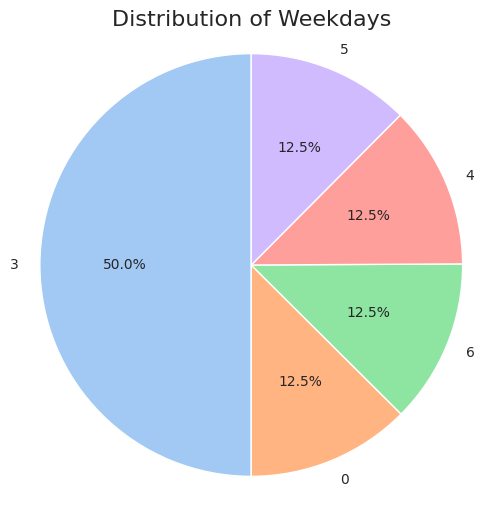

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Get the counts of each weekday
week_day_type_counts = flight_filtered_df['week_day'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(week_day_type_counts,
        labels=week_day_type_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel", len(week_day_type_counts)))

# Add title and improve appearance
plt.title('Distribution of Weekdays', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

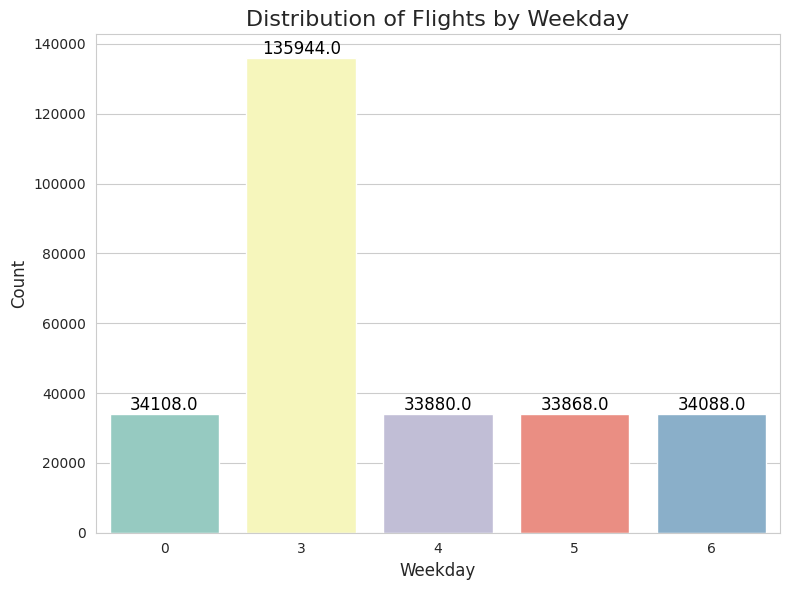

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('Set3')

# Create the count plot
plt.figure(figsize=(8, 6))
count_plot = sns.countplot(x='week_day', data=flight_filtered_df, palette='Set3')

# Add title and labels
plt.title('Distribution of Flights by Weekday', fontsize=16)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate counts on top of bars
for p in count_plot.patches:
    count_plot.annotate(f'{p.get_height()}',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

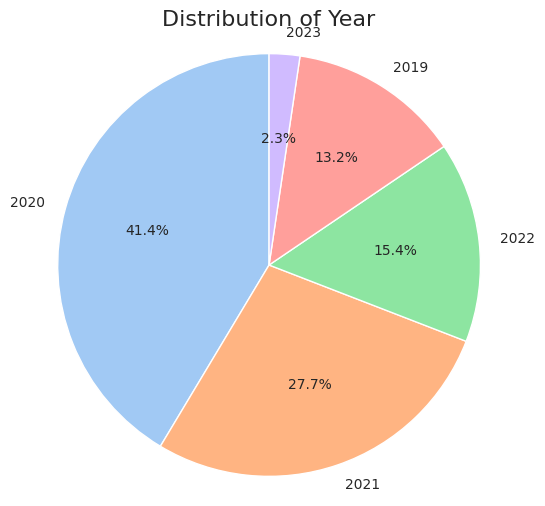

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Get the counts of each year
year_counts = flight_filtered_df['year'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(year_counts,
        labels=year_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel", len(year_counts)))

# Add title and improve appearance
plt.title('Distribution of Year', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

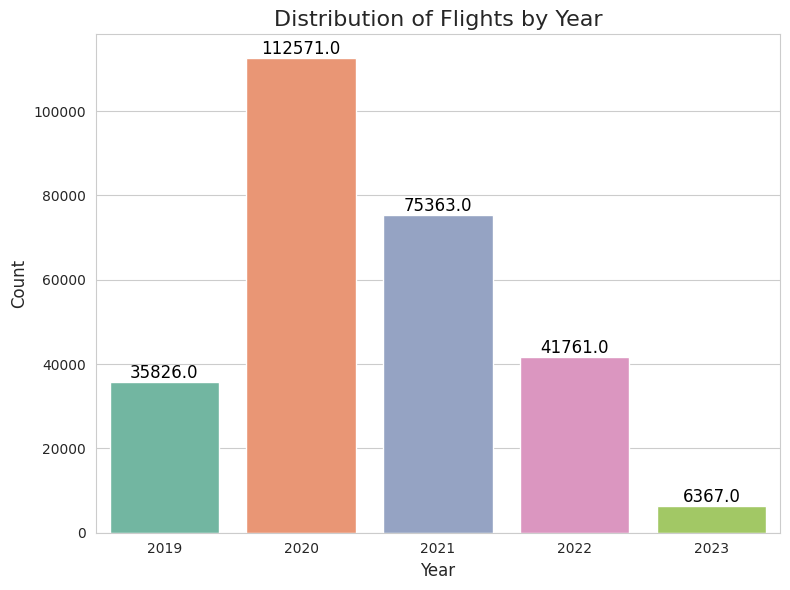

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Create the count plot
plt.figure(figsize=(8, 6))
count_plot = sns.countplot(x='year', data=flight_filtered_df, palette='Set2')

# Add title and labels
plt.title('Distribution of Flights by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate counts on top of bars
for p in count_plot.patches:
    count_plot.annotate(f'{p.get_height()}',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

### **Check for Linear relationship btwn Independent numerical Variable and Target variable**

<Figure size 800x500 with 0 Axes>

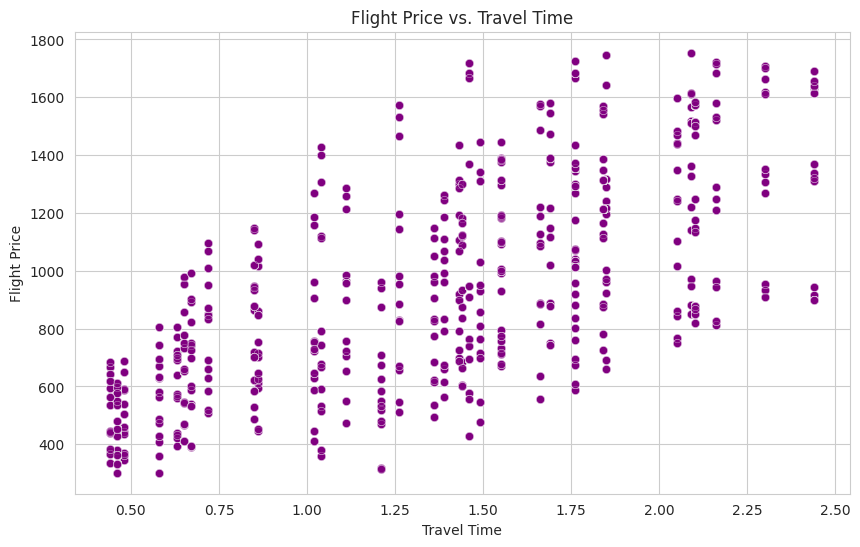

In [ ]:
# Data visualization with improved aesthetics
sns.set_style('whitegrid')
sns.set_palette('pastel')
plt.figure(figsize=(8,5))  # Reduced figure size
# Data visualization
# Price vs. Travel Time

plt.figure(figsize=(10, 6))
sns.scatterplot(data=flight_filtered_df, x='time', y='price', color='purple', alpha=0.5)
plt.title('Flight Price vs. Travel Time')
plt.xlabel('Travel Time')
plt.ylabel('Flight Price')
plt.show()

<Figure size 800x500 with 0 Axes>

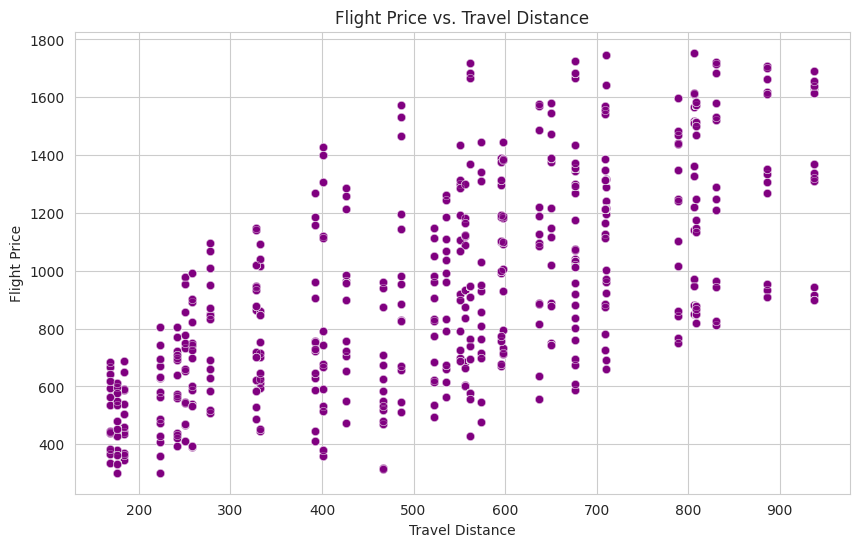

In [ ]:
# Data visualization with improved aesthetics
sns.set_style('whitegrid')
sns.set_palette('pastel')
plt.figure(figsize=(8,5))  # Reduced figure size
# Data visualization
# Price vs. Travel Distance

plt.figure(figsize=(10, 6))
sns.scatterplot(data=flight_filtered_df, x='distance', y='price', color='purple', alpha=0.5)
plt.title('Flight Price vs. Travel Distance')
plt.xlabel('Travel Distance')
plt.ylabel('Flight Price')
plt.show()


1. **Price vs. Hotel Ratings Plot**:
   - The plot examines the relationship between "Hotel Ratings" and "Per Person Price" for travel packages.
   - Each point represents a travel package, with its price on the y-axis and hotel ratings on the x-axis.

2. **Inference**:
   - There doesn't seem to be a strong linear correlation between hotel ratings and per person price.
   - Most data points are scattered across the plot, indicating that hotel ratings alone may not be a dominant factor in determining the price of travel packages.
   - However, there are some clusters of points, suggesting that specific rating ranges may have an impact on price within certain regions.

### **Check for Outliers in Categorical Coulmns**

<Figure size 800x500 with 0 Axes>

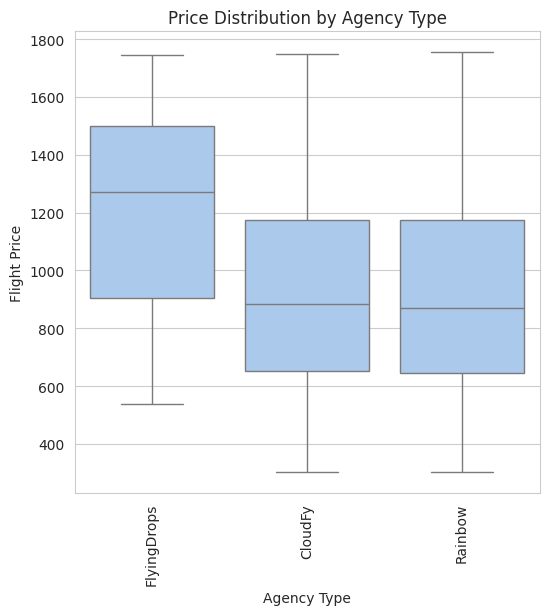

In [ ]:
# Data visualization with improved aesthetics
sns.set_style('whitegrid')
sns.set_palette('pastel')
plt.figure(figsize=(8,5))  # Reduced figure size
# Data visualization
# Box Plots:
# Visualize the distribution of prices per agency type:

plt.figure(figsize=(6,6))
sns.boxplot(data=flight_filtered_df, x='agency', y='price')
plt.xticks(rotation=90)
plt.xlabel('Agency Type')
plt.ylabel('Flight Price')
plt.title('Price Distribution by Agency Type')
plt.show()

<Figure size 800x500 with 0 Axes>

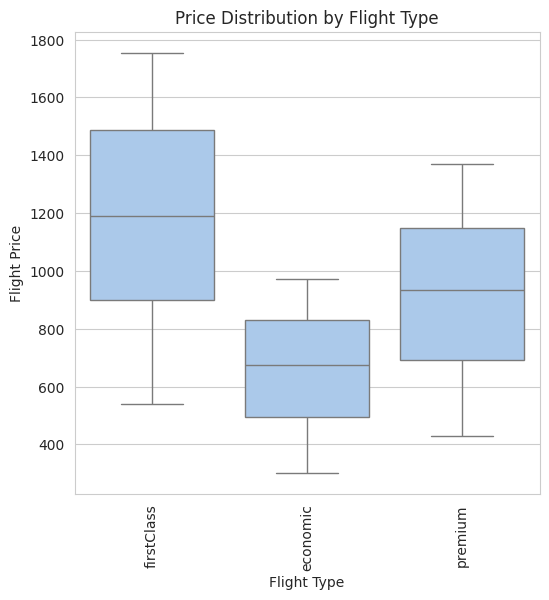

In [ ]:
# Data visualization with improved aesthetics
sns.set_style('whitegrid')
sns.set_palette('pastel')
plt.figure(figsize=(8,5))  # Reduced figure size
# Data visualization
# Box Plots:
# Visualize the distribution of prices per Flight type:

plt.figure(figsize=(6, 6))
sns.boxplot(data=flight_filtered_df, x='flightType', y='price')
plt.xticks(rotation=90)
plt.xlabel('Flight Type')
plt.ylabel('Flight Price')
plt.title('Price Distribution by Flight Type')
plt.show()

<Figure size 800x500 with 0 Axes>

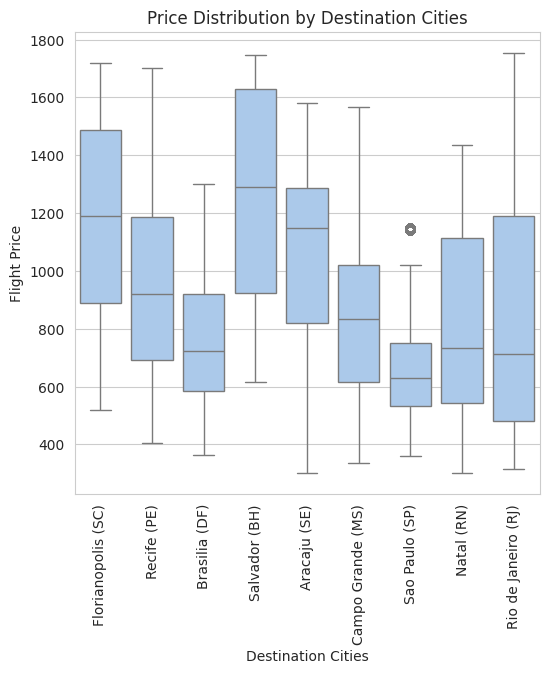

In [ ]:
# Data visualization with improved aesthetics
sns.set_style('whitegrid')
sns.set_palette('pastel')
plt.figure(figsize=(8,5))  # Reduced figure size
# Data visualization
# Box Plots:
# Visualize the distribution of prices per Destination Cities:

plt.figure(figsize=(6, 6))
sns.boxplot(data=flight_filtered_df, x='to', y='price')
plt.xticks(rotation=90)
plt.xlabel('Destination Cities')
plt.ylabel('Flight Price')
plt.title('Price Distribution by Destination Cities')
plt.show()

**Inference of the plot**:

1. **Variability**: The box plots reveal varying levels of price variability within different package types. Some package types have a wider range of prices (larger boxes), while others have narrower ranges (smaller boxes).

2. **Outliers**: Outliers, represented as individual points beyond the "whiskers" of the boxes, can be seen in several package types. These outliers indicate some extreme price values within those categories.

3. **Median Prices**: The horizontal line inside each box represents the median price for each package type. It's a quick way to compare the typical prices across different categories.

4. **Package Type Impact**: The plot provides a visual sense of how package type influences price distribution. Some package types consistently have higher or lower prices than others.

###**Visualize the distribution of prices per Categorical Coulmns using bar-plot**

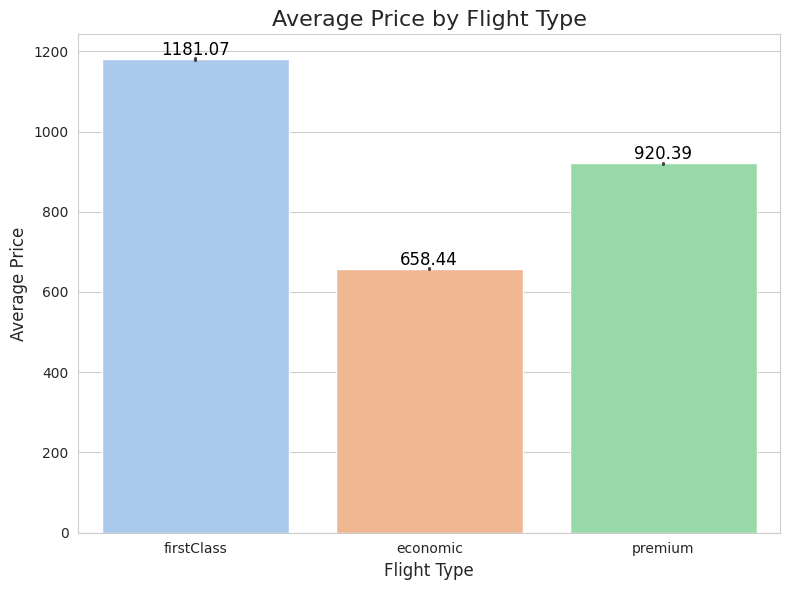

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Create the bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='flightType', y='price', data=flight_filtered_df, palette='pastel')

# Add title and labels
plt.title('Average Price by Flight Type', fontsize=16)
plt.xlabel('Flight Type', fontsize=12)
plt.ylabel('Average Price', fontsize=12)

# Annotate values on top of bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}',
                      (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

The mean most expensive flight Class Type was the FirstClass, followed by Premium Class and Economic Class.

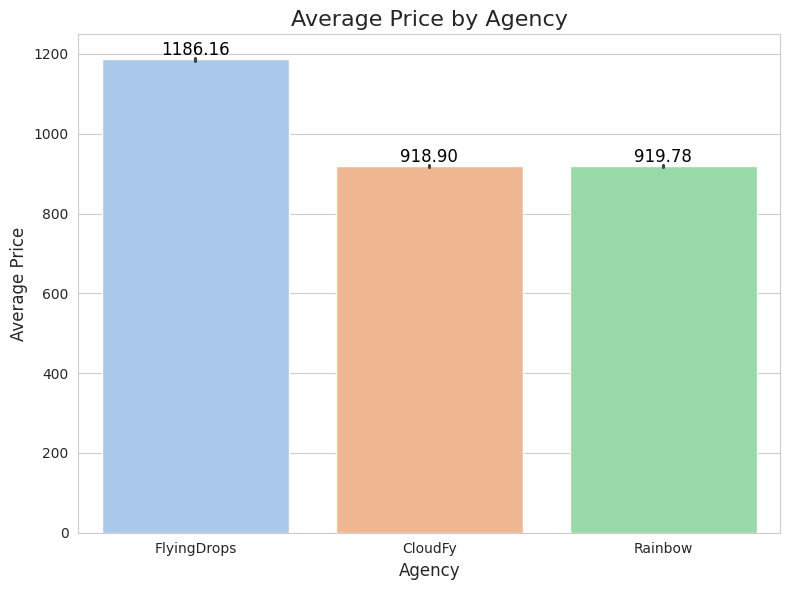

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Create the bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='agency', y='price', data=flight_filtered_df, palette='pastel')

# Add title and labels
plt.title('Average Price by Agency', fontsize=16)
plt.xlabel('Agency', fontsize=12)
plt.ylabel('Average Price', fontsize=12)

# Annotate values on top of bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}',
                      (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

The mean most expensive flight tickets booked by agency was Flyingdrops, followed by Rainbow Class and Cloudfy agency.

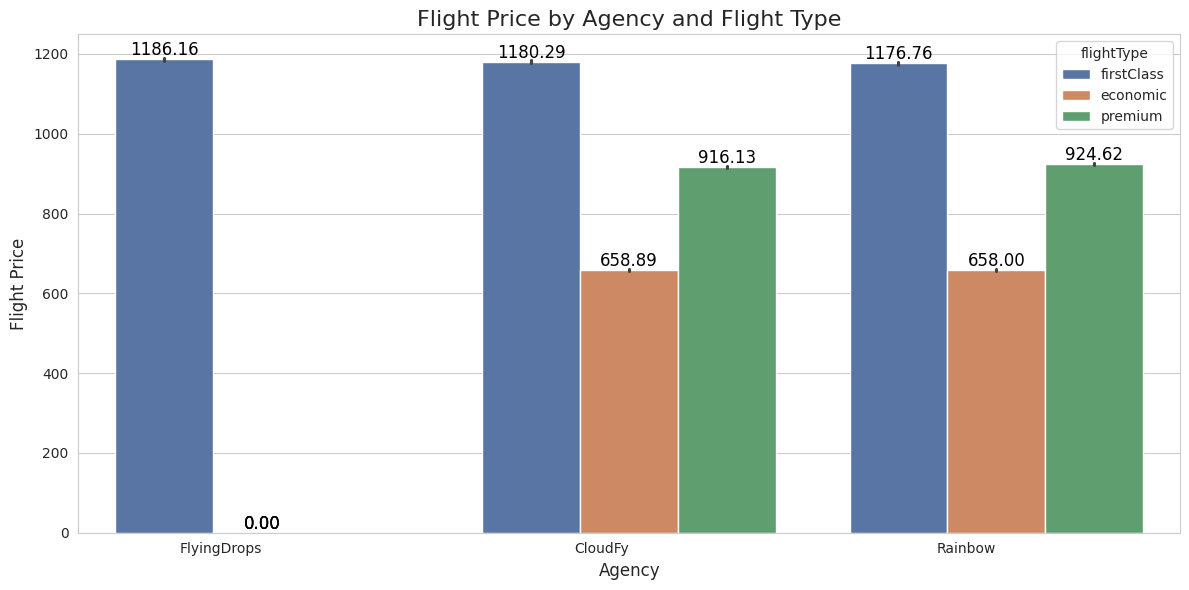

In [ ]:
# Set style and a new color palette
sns.set_style('whitegrid')
sns.set_palette('deep')

# Create the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=flight_filtered_df, x='agency', y='price', hue='flightType')

# Adjust plot appearance
plt.xticks(rotation=0, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Agency', fontsize=12)
plt.ylabel('Flight Price', fontsize=12)
plt.title('Flight Price by Agency and Flight Type', fontsize=16)

# Annotate values on top of bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}',
                      (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha='center', va='bottom', fontsize=12, color='black')

# Show the plot
plt.tight_layout()
plt.show()

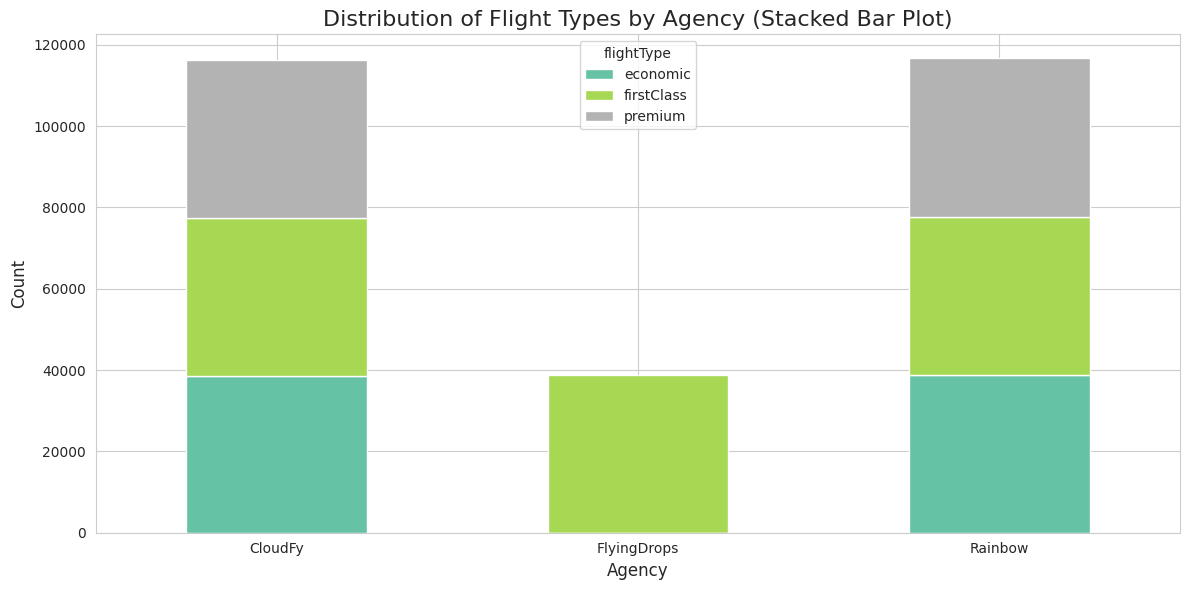

In [ ]:
# Create the stacked bar plot
flight_package_counts = flight_filtered_df.groupby(['agency', 'flightType']).size().unstack(fill_value=0)

# Plot with better styling
ax = flight_package_counts.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='Set2')

# Add labels and title
plt.xlabel('Agency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Flight Types by Agency (Stacked Bar Plot)', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

Inference of the plot:

The plot shows that the agency Flyingdrops is quite popular in booking only first class tickets to its customers and no bookings in any other flight type"

On the contrary, rest two agencies are helping their customers to book their tickets in various flight Class apart from First Class. Both these agencies work in pretty much similar price ranges.

This information suggests that Flyingdrops only deals with HNI or Premium Customers and there is no diverse option apart from FirstClass Type for the customers.

Inference from the plot:

The stacked bar plot visualizes the distribution of package types by start city in the dataset.

In each start city, the stacked bars represent the different package types (Deluxe, Standard, Premium, Luxury, Budget).
For example, in New Delhi Deluxe and Standard packages are more prevalent
This plot allows you to see how the distribution of package types varies across both start cities, providing insights into regional preferences for package types.

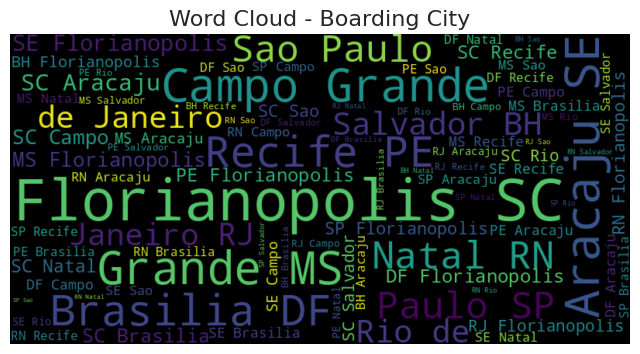

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('deep')

# Generate the word cloud for 'Boarding City'
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(flight_filtered_df['from']))

# Display the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud - Boarding City', fontsize=16)
plt.show()

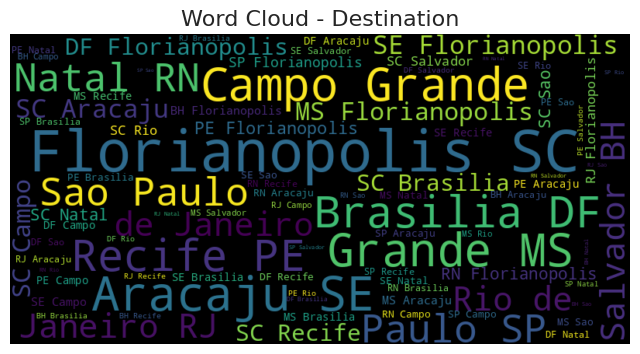

In [ ]:
# Set style and palette
sns.set_style('whitegrid')
sns.set_palette('deep')

# Generate the word cloud for 'Destination'
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(flight_filtered_df['to']))

# Display the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud - Destination', fontsize=16)
plt.show()

Inference from the plot:

The word cloud plot for the "Destination" column visually represents the most common words found in the text data. From the plot, it appears that some of the frequently mentioned destinations include Shimla, Manali, Thekkady, Alleppey, Munnar, and New Delhi. These destinations seem to be popular or commonly mentioned in the dataset.



---


# **Feature Engineering**

In [ ]:
# renaming the Column name
flight_filtered_df.rename(columns={"to":"destination"},inplace=True)

In [ ]:
# Creating a new feature using distance and time columns
flight_filtered_df['flight_speed']=round(flight_filtered_df['distance']/flight_filtered_df['time'],2)

In [ ]:
flight_filtered_df.head()

,from,destination,flightType,agency,time,distance,day,month,year,week_day,week_no,price,flight_speed
0,Recife (PE),Florianopolis (SC),firstClass,FlyingDrops,1.76,676.53,26,9,2019,3,39,1434.38,384.39
1,Florianopolis (SC),Recife (PE),firstClass,FlyingDrops,1.76,676.53,30,9,2019,0,40,1292.29,384.39
2,Brasilia (DF),Florianopolis (SC),firstClass,CloudFy,1.66,637.56,3,10,2019,3,40,1487.52,384.07
3,Florianopolis (SC),Brasilia (DF),firstClass,CloudFy,1.66,637.56,4,10,2019,4,40,1127.36,384.07
4,Aracaju (SE),Salvador (BH),firstClass,CloudFy,2.16,830.86,10,10,2019,3,41,1684.05,384.66


<Axes: xlabel='flight_speed'>

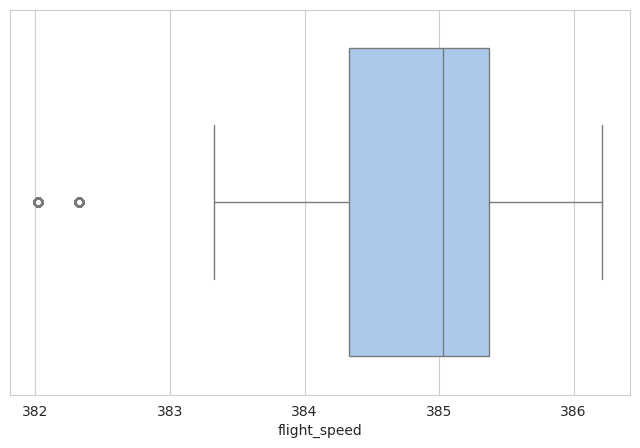

In [ ]:
# Data visualization with improved aesthetics
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_palette('pastel')
plt.figure(figsize=(8,5))  # Reduced figure size
# Data visualization
sns.boxplot(x=flight_filtered_df['flight_speed'])

In [ ]:
Q1= np.percentile(flight_filtered_df['flight_speed'],25)
Q3= np.percentile(flight_filtered_df['flight_speed'],75)
IQR= Q3-Q1

lower_bound= Q1- IQR*1.5
upper_bound= Q3+IQR*1.5

The distribution of flight speed coulmn in the above graph is indicating a left skew due to outliers ,these outliers we can see in box plot occuring below the flight speed of 383km/hr. It may be not considered as outlier in this case,because these are valid data poits and these speed occured due to bad weather condition most probably.

In [ ]:
df=flight_filtered_df.copy()
df.describe()

,time,distance,day,month,year,week_day,week_no,price,flight_speed
count,271888.000000,271888.000000,271888.000000,271888.000000,271888.000000,271888.000000,271888.0,271888.00000,271888.000000
mean,1.421147,546.955535,15.790458,6.607519,2020.522862,3.373521,27.04532,957.37503,384.785156
std,0.542541,208.851288,8.826961,3.606611,0.980161,1.655530,15.793449,362.31189,0.850795
min,0.440000,168.220000,1.000000,1.000000,2019.000000,0.000000,1.0,301.51000,382.020000
25%,1.040000,401.660000,8.000000,3.000000,2020.000000,3.000000,13.0,672.66000,384.330000
50%,1.460000,562.140000,16.000000,7.000000,2020.000000,3.000000,27.0,904.00000,385.030000
75%,1.760000,676.530000,24.000000,10.000000,2021.000000,4.000000,42.0,1222.24000,385.370000
max,2.440000,937.770000,31.000000,12.000000,2023.000000,6.000000,53.0,1754.17000,386.210000


In [ ]:
flight_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   from          271888 non-null  object 
 1   destination   271888 non-null  object 
 2   flightType    271888 non-null  object 
 3   agency        271888 non-null  object 
 4   time          271888 non-null  float64
 5   distance      271888 non-null  float64
 6   day           271888 non-null  int32  
 7   month         271888 non-null  int32  
 8   year          271888 non-null  int32  
 9   week_day      271888 non-null  int32  
 10  week_no       271888 non-null  UInt32 
 11  price         271888 non-null  float64
 12  flight_speed  271888 non-null  float64
dtypes: UInt32(1), float64(4), int32(4), object(4)
memory usage: 22.0+ MB


In [ ]:
# Example of one-hot encoding
flight_filtered_df = pd.get_dummies(flight_filtered_df, columns=['from','destination','flightType','agency'])

In [ ]:
flight_filtered_df.shape

(271888, 33)



# **Feature Selection**

##**Feature Selection Using Statistical Test ANNOVA F-Test**

In [ ]:
final_df1= flight_filtered_df.drop(columns=['time','flight_speed','month','year','distance'],axis=1)

In [ ]:
# Assuming df is your DataFrame with features and target variable 'target'

# Separate features (X) and target variable (y)
X = final_df1.drop('price', axis=1)  # Features
y = final_df1['price']                # Target variable

# Select top k features based on chi-squared test for categorical features
#categorical_features = X.select_dtypes(include=['object', 'category']).columns
num_features = X.select_dtypes(include=['number']).columns

# ANOVA F-test for numerical features
# Set k to a value less than or equal to the number of numerical features (3 in this case)
f_selector = SelectKBest(score_func=f_classif, k=3)  # Change k to 3 or less
f_selector.fit(X[num_features], y)

# Get indices of top k features for both categorical and numerical features

numerical_top_indices = f_selector.get_support(indices=True)

# Combine top indices
top_indices = list(numerical_top_indices)

# Get top k feature names
top_features = X.columns[top_indices]

# Display top k features
print("Top k selected features:")
print(top_features)

Top k selected features:
Index(['day', 'week_day', 'week_no'], dtype='object')


In [ ]:
# Importing necessary libraries
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Convert all columns to numeric, coercing errors to NaN
    X = X.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any missing values after conversion
    X = X.dropna()

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
X.rename(columns={'from_Sao Paulo (SP)':'from_Sao_Paulo (SP)','from_Rio de Janeiro (RJ)':'from_Rio_de_Janeiro (RJ)','from_Campo Grande (MS)':'from_Campo_Grande (MS)',
                                  'destination_Sao Paulo (SP)':'destination_Sao_Paulo (SP)','destination_Rio de Janeiro (RJ)':'destination_Rio_de_Janeiro (RJ)','destination_Campo Grande (MS)':'destination_Campo_Grande (MS)'},inplace=True)

In [ ]:
features_ordering=['from_Florianopolis (SC)',
 'from_Sao_Paulo (SP)',
 'from_Salvador (BH)',
 'from_Brasilia (DF)',
 'from_Rio_de_Janeiro (RJ)',
 'from_Campo_Grande (MS)',
 'from_Aracaju (SE)',
 'from_Natal (RN)',
 'from_Recife (PE)',
 'destination_Florianopolis (SC)',
 'destination_Sao_Paulo (SP)',
 'destination_Salvador (BH)',
 'destination_Brasilia (DF)',
 'destination_Rio_de_Janeiro (RJ)',
 'destination_Campo_Grande (MS)',
 'destination_Aracaju (SE)',
 'destination_Natal (RN)',
 'destination_Recife (PE)',
 'flightType_economic',
 'flightType_firstClass',
 'flightType_premium',
 'agency_Rainbow',
 'agency_CloudFy',
 'agency_FlyingDrops',
 'week_no',
 'week_day',
 'day']

In [ ]:
#Ordering features based on flask output
final_features_1= X[features_ordering]

In [ ]:
X1= final_features_1

# Target variable
y1 = y

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler_new = StandardScaler()

X_train1 = scaler_new.fit_transform(X_train1)
X_test1 = scaler_new.transform(X_test1)

In [ ]:
final_features_1.columns

Index(['from_Florianopolis (SC)', 'from_Sao_Paulo (SP)', 'from_Salvador (BH)',
       'from_Brasilia (DF)', 'from_Rio_de_Janeiro (RJ)',
       'from_Campo_Grande (MS)', 'from_Aracaju (SE)', 'from_Natal (RN)',
       'from_Recife (PE)', 'destination_Florianopolis (SC)',
       'destination_Sao_Paulo (SP)', 'destination_Salvador (BH)',
       'destination_Brasilia (DF)', 'destination_Rio_de_Janeiro (RJ)',
       'destination_Campo_Grande (MS)', 'destination_Aracaju (SE)',
       'destination_Natal (RN)', 'destination_Recife (PE)',
       'flightType_economic', 'flightType_firstClass', 'flightType_premium',
       'agency_Rainbow', 'agency_CloudFy', 'agency_FlyingDrops', 'week_no',
       'week_day', 'day'],
      dtype='object')

In [ ]:
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Function to train a model and return evaluation metrics
def train_model(model_name, X_train, y_train, X_test, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge": Ridge(alpha=1),
        "Lasso": Lasso(alpha=0.1),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest": RandomForestRegressor(),
        "XGBoost": XGBRegressor()
    }

    # Select the model
    model = models[model_name]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    # Return model and its metrics
    return {
        "Model": model_name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Adj R2": adj_r2,
        "Trained Model": model  # Store trained model for later use
    }

In [ ]:
# Initialize an empty DataFrame to store results
model_results = pd.DataFrame()

# Dictionary to store trained models
trained_models = {}

# List of models to train
models = ["Linear Regression", "Ridge", "Lasso", "Decision Tree", "Random Forest", "XGBoost"]

# Train all models and store results
for model_name in models:
    result = train_model(model_name, X_train1, y_train1, X_test1, y_test1)
    trained_models[model_name] = result["Trained Model"]  # Save model
    model_results = pd.concat([model_results, pd.DataFrame([result])], ignore_index=True)

# Display final results
print(model_results)

               Model           MSE        RMSE         MAE        R2  \
0  Linear Regression  47023.080700  216.848059  165.358445  0.643141   
1              Ridge  47023.078125  216.848053  165.358494  0.643141   
2              Lasso  47021.965318  216.845487  165.382576  0.643149   
3      Decision Tree      1.444471    1.201862    0.020061  0.999989   
4      Random Forest      0.319909    0.565605    0.039137  0.999998   
5            XGBoost      4.793237    2.189346    1.602110  0.999964   

     Adj R2                                      Trained Model  
0  0.642963                                 LinearRegression()  
1  0.642963                                     Ridge(alpha=1)  
2  0.642972                                   Lasso(alpha=0.1)  
3  0.999989                            DecisionTreeRegressor()  
4  0.999998  (DecisionTreeRegressor(max_features=1.0, rando...  
5  0.999964  XGBRegressor(base_score=None, booster=None, ca...  


#**Benchmark Models**

In [ ]:
# Benchmark Model based on RMSE
best_rmse_model_name = model_results.loc[model_results['RMSE'].idxmin(), 'Model']
best_rmse_model = trained_models[best_rmse_model_name]

# Benchmark Model based on Adjusted R2
best_adj_r2_model_name = model_results.loc[model_results['Adj R2'].idxmax(), 'Model']
best_adj_r2_model = trained_models[best_adj_r2_model_name]

# Benchmark Models based on both RMSE and Adjusted R2
filtered_results = model_results[
    (model_results['Adj R2'] == model_results['Adj R2'].max()) |
    (model_results['RMSE'] == model_results['RMSE'].min())
]

print("\nBest Model based on RMSE:", best_rmse_model_name)
print("\nBest Model based on Adjusted R2:", best_adj_r2_model_name)
print("\nBest Models based on RMSE & Adjusted R2:")
print(filtered_results)


Best Model based on RMSE: Random Forest

Best Model based on Adjusted R2: Random Forest

Best Models based on RMSE & Adjusted R2:
           Model       MSE      RMSE       MAE        R2    Adj R2  \
4  Random Forest  0.319909  0.565605  0.039137  0.999998  0.999998   

                                       Trained Model  
4  (DecisionTreeRegressor(max_features=1.0, rando...  


In [ ]:
# Define the save path (update if needed)
save_path = "/content/drive/MyDrive/Master Degree Capstone/Travel Pridiction/Flight Prediction"

# Save the scaler
pickle.dump(scaler_new, open(save_path + "scaling.pkl", "wb"))

# Save the best models
pickle.dump(best_rmse_model, open(save_path + "best_rmse_model.pkl", "wb"))
pickle.dump(best_adj_r2_model, open(save_path + "best_adj_r2_model.pkl", "wb"))

# Save all trained models separately
for model_name, model in trained_models.items():
    filename = save_path + model_name.lower().replace(" ", "_") + ".pkl"
    pickle.dump(model, open(filename, "wb"))

print("All models and scaler saved successfully!")

All models and scaler saved successfully!
